# Active space selection for NA-MD simulations 

In this tutorial, we show how the selection of active space should be performed. Here, we select a short snapshot 
of the $C_{20}$ fullerene structure where its molecular orbitals show a band like structure. We will show how the selection of 
the `lowest_orbital` and `highest_orbital` variables in step 2 can affect the results of the time-overlap matrix elements. 
We show this in the many-body basis. This can lead to **sudden jumps** or faster population transfer dynamics and unphysical results. 


## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Plotting the Kohn-Sham energies](#plot_ks_energies)
4. [Plot results](#plot_res)
5. [NA-MD in bases with different active spaces](#namd)
   

## Learning objectives

* To be able to wisely select the active space for computing the excited states basis

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Import `glob`, `numpy`, `scipy.sparse`, `matplotlib.pyplot`, and `step3` module which is used to compute the NACs in Kohn-Sham basis using `run_step3_ks_nacs_libint` and in excited states basis using `run_step3_sd_nacs_libint`. 

In [2]:
import os, glob, time, h5py, warnings
import numpy as np
import scipy.sparse as sp
from libra_py import units, data_stat, influence_spectrum, data_conv
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3
import libra_py.packages.cp2k.methods as CP2K_methods
from IPython.display import clear_output
import multiprocessing as mp

import util.libutil as comn
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.workflows.nbra.decoherence_times as decoherence_times

from recipes import fssh_nbra
# from recipes import dish_nbra, fssh_nbra, fssh2_nbra, gfsh_nbra, ida_nbra, mash_nbra, msdm_nbra

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

The MO overlap files are needed and stored in this folder.

* `./step2_data`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index.

## 3. Plotting the Kohn-Sham energy levels <a name="plot_ks_energies"></a>
[Back to TOC](#toc)

Let's first plot the energy levels of the Kohn-Sham molecular orbitals.

In this case, the HOMO energy level is 40 (starting from 1) but the active space variables are `lowest_orbital`: 40-19 and `highest_orbital`: 40+20 in step 2. So, the index of the HOMO is 19 (starting from 0). The **band gap in this system is small** (see the gap between the green and red levels) but here we just want to show how the active space selection can affect the ground state time-overlaps.

(80,)
(300, 40)


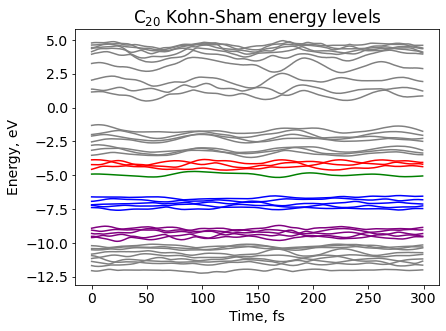

In [3]:
%matplotlib inline

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(3.21*2,2.41*2))
# ===== Reading the energies
energies = []
for i in range(1200,1500):
    energy = np.diag(sp.load_npz(f'step2_data/res/E_ks_{i}.npz').toarray())
    energy_shape = int(energy.shape[0]/2)
    energies.append(energy[0:energy_shape])
print(energy.shape)
energies = np.array(energies)
print(energies.shape)
energies = energies*units.au2ev
# ===== Plotting the energy vs time
for i in range(energies.shape[1]):
    if i==19:
        color = 'green'
    elif i<=18 and i>=14:
        color = 'blue'
    elif i>=20 and i<23:
        color = 'red'
    elif i>=9 and i<14:
        color = 'purple'
    else:
        color = 'gray'
    plt.plot(energies[:,i], color=color)
# plt.ylim()   
plt.xlabel('Time, fs')
plt.ylabel('Energy, eV')
plt.title('C$_{20}$ Kohn-Sham energy levels')
plt.tight_layout()

## 4. Excited state basis <a name="excited_states"></a>
[Back to TOC](#toc)

Similar to what we had in [step 3](../8_step3), we will build the excited states basis. If we don't select all the orbitals in one band that are more probable to cross each other, the state-tracking algorithm will not be able to track the states properly and will result in sudden jump errors when doing nonadiabatic dynamics. 

If we select the orbitals in a band by `num_occ_orbitals: 6` (at this point we only want to check the ground state so doesn't matter what is the selection of unoccupied orbtitals and we keep it at 5), and plot the time-overlap of the ground state with itself (the first diagonal element of the time-overlap matrix). We see that the magnitudes are very close to 1.0 which is desired for the ground state and will not result in sudden jumps. 


In [4]:
params_active_space = {
    'lowest_orbital': 40-19, 'highest_orbital': 40+20, 'num_occ_orbitals': 6, 'num_unocc_orbitals': 5,
    'path_to_npz_files': os.getcwd()+'/step2_data/res', 'logfile_directory': os.getcwd()+'/step2_data/all_logfiles',
    'path_to_save_npz_files': os.getcwd()+'/step2_data/new_res'
}
new_lowest_orbital, new_highest_orbital = step3.limit_active_space(params_active_space)

mkdir: cannot create directory ‘/projects/academic/alexeyak/mohammad/my_repositories/Tutorials_Libra/6_dynamics/2_nbra_workflows/17_active_space_selection/step2_data/new_res’: File exists


Restricting the active space for S..
Restricting the active space for St..
Restricting the active space for E..
Done with limiting the active space
Your new path_to_npz_files is now: /projects/academic/alexeyak/mohammad/my_repositories/Tutorials_Libra/6_dynamics/2_nbra_workflows/17_active_space_selection/step2_data/new_res
Use the new lowest_orbital: 35 and highest_orbital: 45


In [5]:
params_mb_sd = {
          'lowest_orbital': new_lowest_orbital, 'highest_orbital': new_highest_orbital, 'num_occ_states': 6, 'num_unocc_states': 5,
          'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.0, 'verbosity': 0, 'use_multiprocessing': True, 'nprocs': 4,
          'is_many_body': True, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': params_active_space['path_to_save_npz_files'],
          'logfile_directory': os.getcwd()+'/step2_data/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-sd-6-occ',
          'outdir': os.getcwd()+'/res-sd-6-occ', 'start_time': 1200, 'finish_time': 1499, 'sorting_type': 'energy',
         }

step3.run_step3_sd_nacs_libint(params_mb_sd)
clear_output()

In [6]:
# Reading the diagonal elements of the time-overlap matix
time_overlaps = []
for i in range(1200,1498):
    St = sp.load_npz(f'res-sd-6-occ/St_sd_{i}_re.npz').todense().real
    time_overlaps.append(np.diag(St))
time_overlaps = np.array(time_overlaps)

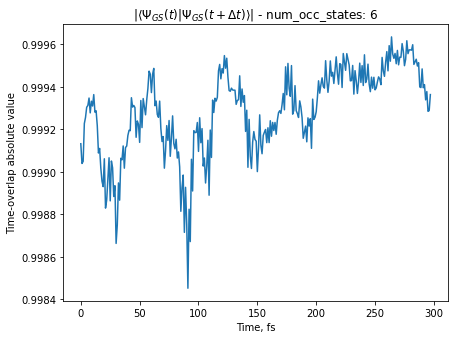

In [7]:
%matplotlib inline
plt.figure(figsize=(3.21*2,2.41*2))
plt.title('$\\|\\langle\\Psi_{GS}(t)\\|\\Psi_{GS}(t+\\Delta t)\\rangle\\|$ - num_occ_states: 6')
plt.plot(np.arange(time_overlaps.shape[0]), np.abs(time_overlaps[:,0]))
plt.xlabel('Time, fs')
plt.ylabel('Time-overlap absolute value')
plt.tight_layout()

Now, let's try with 7 occupied orbitals and do the same as above:

In [8]:
params_active_space.update({'num_occ_orbitals': 7})
new_lowest_orbital, new_highest_orbital = step3.limit_active_space(params_active_space)
params_mb_sd.update({'lowest_orbital': new_lowest_orbital, 'highest_orbital': new_highest_orbital, 
                     'path_to_save_sd_Hvibs':'res-sd-7-occ'})
step3.run_step3_sd_nacs_libint(params_mb_sd)
clear_output()

In [9]:
# Reading the diagonal elements of the time-overlap matix
time_overlaps = []
for i in range(1200,1498):
    St = sp.load_npz(f'res-sd-7-occ/St_sd_{i}_re.npz').todense().real
    time_overlaps.append(np.diag(St))
time_overlaps = np.array(time_overlaps)

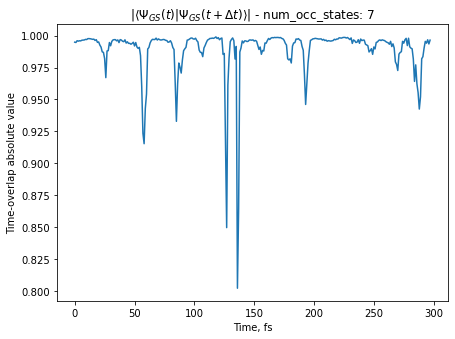

In [10]:
%matplotlib inline
plt.figure(figsize=(3.21*2,2.41*2))
plt.title('$\\|\\langle\\Psi_{GS}(t)\\|\\Psi_{GS}(t+\\Delta t)\\rangle\\|$ - num_occ_states: 7')
plt.plot(np.arange(time_overlaps.shape[0]), np.abs(time_overlaps[:,0]))
plt.xlabel('Time, fs')
plt.ylabel('Time-overlap absolute value')
plt.tight_layout()

Let's try with other values and make this procedure automated. By `8`, we still are not including all the occupied orbitals in the second band. By `11` we select all the second band occupied orbitals. But if we go to `12`, it will only add the first orbital in the third band and will cause time-overlap problem. The situation can get worse for other steps. Since in many-body calculations, the time-overlaps related to single-particle is used, similar thing will happen. So, make sure to properly select the `lowest_orbital` and `highest_orbital`. 

In [11]:
all_time_overlaps = []
num_occ_states = [8,11,12]
for num_occ_state in num_occ_states:
    print('Doing the calculations for:', num_occ_state)
    params_active_space.update({'num_occ_orbitals': num_occ_state})
    new_lowest_orbital, new_highest_orbital = step3.limit_active_space(params_active_space)
    params_mb_sd.update({'lowest_orbital': new_lowest_orbital, 'highest_orbital': new_highest_orbital,
                         'path_to_save_sd_Hvibs':f'res-sd-{num_occ_state}-occ'})
    step3.run_step3_sd_nacs_libint(params_mb_sd)
    clear_output()
    time_overlaps = []
    for i in range(1200,1498):
        St = sp.load_npz(f'res-sd-{num_occ_state}-occ/St_sd_{i}_re.npz').todense().real
        time_overlaps.append(np.diag(St))
    time_overlaps = np.array(time_overlaps)
    all_time_overlaps.append(time_overlaps)

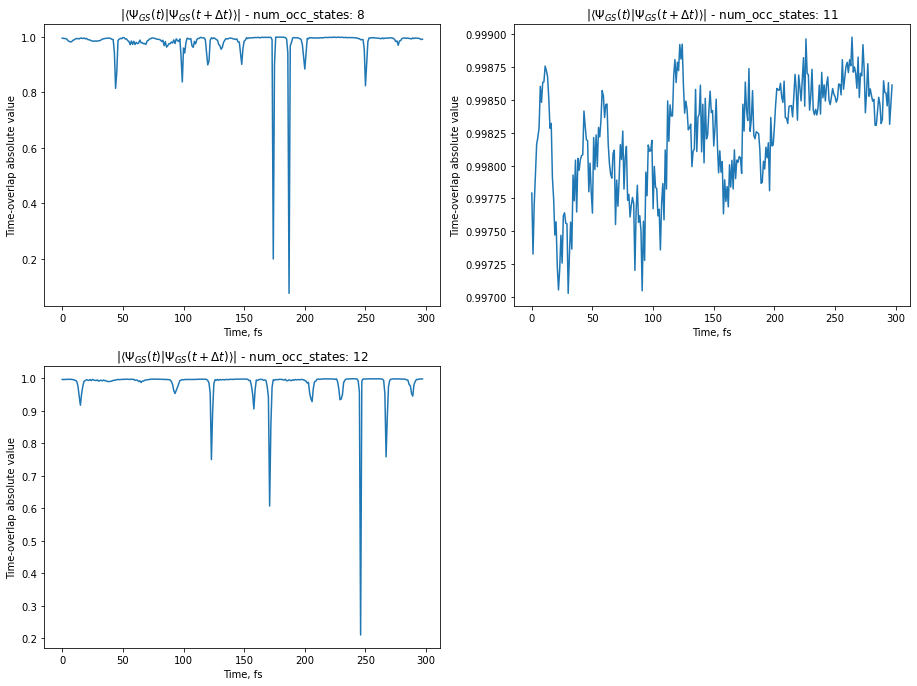

In [12]:
%matplotlib inline
plt.figure(figsize=(3.21*4,2.41*4))
for i in range(len(all_time_overlaps)):
    time_overlaps = all_time_overlaps[i]
    plt.subplot(2,2,i+1)
    plt.title(f'$\\|\\langle\\Psi_{{GS}}(t)\\|\\Psi_{{GS}}(t+\\Delta t)\\rangle\\|$ - num_occ_states: {num_occ_states[i]}')
    plt.plot(np.arange(time_overlaps.shape[0]), np.abs(time_overlaps[:,0]))
    plt.xlabel('Time, fs')
    plt.ylabel('Time-overlap absolute value')
plt.tight_layout()

## 5. NA-MD in bases with different active spaces <a name="namd"></a>
[Back to TOC](#toc)

Let's try NA-MD with FSSH and a few number of surface hopping trajectory to see how the results will look like. Here, let's only show the case with 11 and 12 occupied states. All FSSH results are brought in the `data.tar.bz2` file and you dont need to compute them. We are using a similar code as in [step 4](../14_many_recipes). I merged all the input cells from this step in one cell. 

In [ ]:
for nocc in [6,7,8,11,12]:
    path_to_save_sd_Hvibs = f'res-sd-{nocc}-occ'
    istep = 1200
    fstep = 1498
    nsteps = fstep - istep
    #================== Read energies =====================
    E = []
    for step in range(istep,fstep):
        energy_filename = F"{path_to_save_sd_Hvibs}/Hvib_sd_{step}_re.npz"
        energy_mat = sp.load_npz(energy_filename)
        # For data conversion we need to turn np.ndarray to np.array so that 
        # we can use data_conv.nparray2CMATRIX
        E.append( np.array( np.diag( energy_mat.todense() ) ) )
    E = np.array(E)
    NSTATES = E[0].shape[0]
    #================== Read time-overlap =====================
    St = []
    for step in range(istep,fstep):        
        St_filename = F"{path_to_save_sd_Hvibs}/St_sd_{step}_re.npz"
        St_mat = sp.load_npz(St_filename)
        St.append( np.array( St_mat.todense() ) )
    St = np.array(St)
    #================ Compute NACs and vibronic Hamiltonians along the trajectory ============    
    NAC = []
    Hvib = [] 
    for c, step in enumerate(range(istep,fstep)):
        nac_filename = F"{path_to_save_sd_Hvibs}/Hvib_sd_{step}_im.npz"
        nac_mat = sp.load_npz(nac_filename)
        NAC.append( np.array( nac_mat.todense() ) )
        Hvib.append( np.diag(E[c, :])*(1.0+1j*0.0)  - (0.0+1j)*nac_mat[:, :] )

    NAC = np.array(NAC)
    Hvib = np.array(Hvib)

    print('Number of steps:', nsteps)
    print('Number of states:', NSTATES)

    class abstr_class:
        pass

    def compute_model(q, params, full_id):
        timestep = params["timestep"]
        nst = params["nstates"]
        obj = abstr_class()

        obj.ham_adi = data_conv.nparray2CMATRIX( np.diag(E[timestep, : ]) )
        obj.nac_adi = data_conv.nparray2CMATRIX( NAC[timestep, :, :] )
        obj.hvib_adi = data_conv.nparray2CMATRIX( Hvib[timestep, :, :] )
        obj.basis_transform = CMATRIX(nst,nst); obj.basis_transform.identity()  #basis_transform
        obj.time_overlap_adi = data_conv.nparray2CMATRIX( St[timestep, :, :] )

        return obj

    # ================= Computing the energy gaps and decoherence times
    HAM_RE = []
    for step in range(E.shape[0]):
        HAM_RE.append( data_conv.nparray2CMATRIX( np.diag(E[step, : ]) ) )
    # Average decoherence times and rates
    tau, rates = decoherence_times.decoherence_times_ave([HAM_RE], [0], nsteps, 0)
    # Computes the energy gaps between all states for all steps
    dE = decoherence_times.energy_gaps_ave([HAM_RE], [0], nsteps)
    # Decoherence times in fs
    avg_deco = data_conv.MATRIX2nparray(tau) * units.au2fs
    # Zero all the diagonal elements of the decoherence matrix
    np.fill_diagonal(avg_deco, 0)
    # Saving the average decoherence times
    np.savetxt('avg_deco.txt',avg_deco.real)
    # Computing the average energy gaps
    gaps = MATRIX(NSTATES, NSTATES)
    for step in range(nsteps):
        gaps += dE[step]
    gaps /= nsteps
    #================== Model parameters ====================
    model_params = { "timestep":0, "icond":0,  "model0":0, "nstates":NSTATES }

    #=============== Some automatic variables, related to the settings above ===================
    #############
    NSTEPS = 1000
    #############

    dyn_general = { "nsteps":NSTEPS, "ntraj":25, "nstates":NSTATES, "dt":1.0*units.fs2au,
                    "decoherence_rates":rates, "ave_gaps":gaps,                
                    "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),
                    "mem_output_level":2,
                    "properties_to_save":[ "timestep", "time","se_pop_adi", "sh_pop_adi" ],
                    "prefix":F"NBRA", "prefix2":F"NBRA", "isNBRA":0, "nfiles": nsteps - 1
                  }
    ##########################################################
    #============== Select the method =====================
    #dish_nbra.load(dyn_general); prf = "DISH"  # DISH
    fssh_nbra.load(dyn_general); prf = "FSSH"  # FSSH
    #fssh2_nbra.load(dyn_general); prf = "FSSH2"  # FSSH2
    #gfsh_nbra.load(dyn_general); prf = "GFSH"  # GFSH
    #ida_nbra.load(dyn_general); prf = "IDA"  # IDA
    # mash_nbra.load(dyn_general); prf = "MASH"  # MASH
    #msdm_nbra.load(dyn_general); prf = "MSDM"  # MSDM
    ##########################################################

    #=================== Initial conditions =======================
    #============== Nuclear DOF: these parameters don't matter much in the NBRA calculations ===============
    nucl_params = {"ndof":1, "init_type":3, "q":[-10.0], "p":[0.0], "mass":[2000.0], "force_constant":[0.01], "verbosity":-1 }

    #============== Electronic DOF: Amplitudes are sampled ========
    elec_params = {"ndia":NSTATES, "nadi":NSTATES, "verbosity":-1, "init_dm_type":0}

    ###########
    istate = 1
    ###########
    elec_params.update( {"init_type":1,  "rep":1,  "istate":istate } )  # how to initialize: random phase, adiabatic representation

    if prf=="MASH":
        istates = list(np.zeros(NSTATES))
        istates[istate] = 1.0
        elec_params.update( {"init_type":4,  "rep":1,  "istate":3, "istates":istates } )  # different initialization for MASH

    def function1(icond):
        print('Running the calculations for icond:', icond)
        time.sleep( icond * 0.01 )
        rnd=Random()
        mdl = dict(model_params)
        mdl.update({"icond": icond})  #create separate copy
        dyn_gen = dict(dyn_general)
        dyn_gen.update({"prefix":F"{prf}_icond_{icond}_nocc_{nocc}", "prefix2":F"{prf}_icond_{icond}_nocc_{nocc}" })
        res = tsh_dynamics.generic_recipe(dyn_gen, compute_model, mdl, elec_params, nucl_params, rnd)

    ################################
    nthreads = 3
    ICONDS = [0,100,200]
    ################################

    pool = mp.Pool(nthreads)
    pool.map(function1, ICONDS)
    pool.close()                            
    pool.join()
    clear_output()

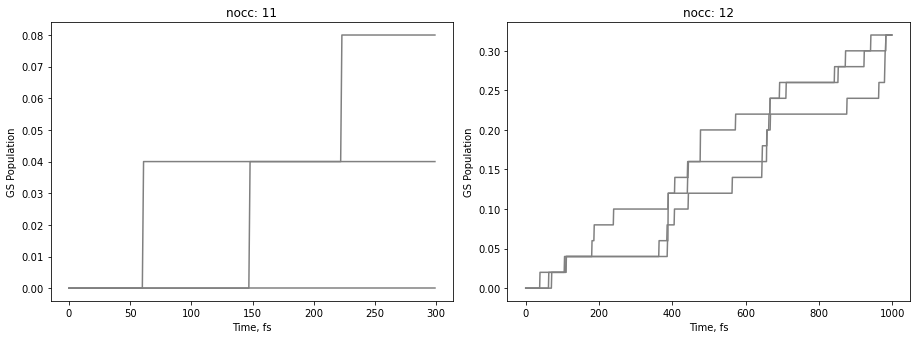

In [9]:
%matplotlib inline
plt.figure(figsize=(3.21*4,2.41*2))
for k, j in enumerate([11,12]):
    plt.subplot(1,2,k+1)
    for icond in [0,100,200]:
        F = h5py.File(f'FSSH_icond_{icond}_nocc_{j}/mem_data.hdf')
        sh_pop = np.array(F['sh_pop_adi/data'])
        #print(sh_pop.shape)
        plt.plot(sh_pop[:,0], color='gray')
        F.close()
    plt.title(f'nocc: {j}')
    plt.ylabel('GS Population')
    plt.xlabel('Time, fs')
    plt.tight_layout()
    